In [561]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scipy
from time import time
import random
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
import os
import glob
from ipywidgets import interact, HTML, FloatSlider, fixed, IntSlider, HBox, VBox, interactive
import ipywidgets as widgets
%matplotlib inline
# print (plt.style.available)

In [562]:
# load FDM module
import sys,importlib
importlib.reload(fdm)
FdmSolver = fdm.FDM()

# Examples of shell structures with mesh


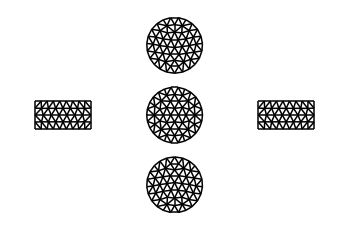

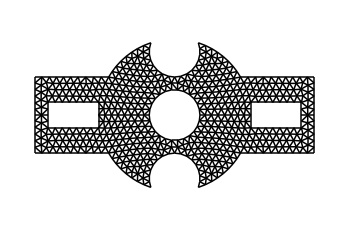

In [563]:
import dmsh
import 5

geo = dmsh.Union([
    dmsh.Circle([0.0, 0.0], 6),
    dmsh.Rectangle(-11.0, -4.0, -3.0,3.0),
    dmsh.Rectangle(4.0, 11.0, -3.0,3.0)
]
)

geo1 = dmsh.Union(
    [dmsh.Circle([0.0, 5.0], 2.0),
     dmsh.Circle([0.0, -5.0], 2.0),
     dmsh.Circle([0.0, 0.0], 2.),
     dmsh.Rectangle(6.0, 10.0, -1.0,1.0),
    dmsh.Rectangle(-10.0, -6.0, -1.0,1.0)
        ]
    )

points, cells = dmsh.generate(geo1, .5, tol=1.0e-5);
_ = meshzoo.plot2d(points, cells)

geo = dmsh.Difference(
    geo,
    geo1
)


points, cells = dmsh.generate(geo, .5, tol=1.0e-5);

edgelist, _ = meshzoo.create_edges(cells)


_ = meshzoo.plot2d(points, cells)




In [564]:
# Convert the mesh to the networkx graph structure
#grid structure
all_poses = {}
dim = 8
G = nx.Graph()


free_nodes_mask = []
free_nodes = []
fixed_nodes = []
fixed_nodes_z = []
xys = []
counter = 0
for n in np.unique(edgelist):
    G.add_node(n)
    all_poses[n] = list(points[n,[0,1]])
for e in edgelist:
    G.add_edge(e[0],e[1])

# degrees = [G.degree[k] for k in G.nodes]
eps = 1.0e-10
border_points = list(np.where(np.abs(geo.dist(points.T)) < eps)[0])


for n in G.nodes:
    if n in border_points:
        fixed_nodes.append(n)
        free_nodes_mask.append(0)
    else:
        free_nodes.append(n)
        free_nodes_mask.append(1)



base_G = G.copy()



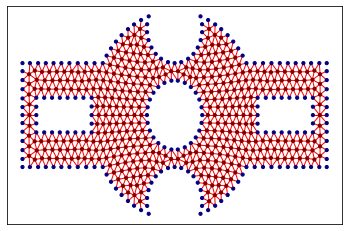

In [565]:
Data_struct = FdmSolver.prepare_graph(base_G,all_poses,fixed_nodes,free_nodes,free_nodes_mask,show_graph=True,node_size=10,node_label=False)

# # We can save it if we want to use it later 
# graph_name = '22.npy'
# json_file  = './Data/'+graph_name
# np.save(json_file, Data_struct) 


# Form finding under different load vectors
### Try changing the load vectors in x,y and z dimensions and see how the final form will be
### The only variable, here is the force density vectors for the free edges. Try to play with it and see what happens

loadpath:7179584.390391113


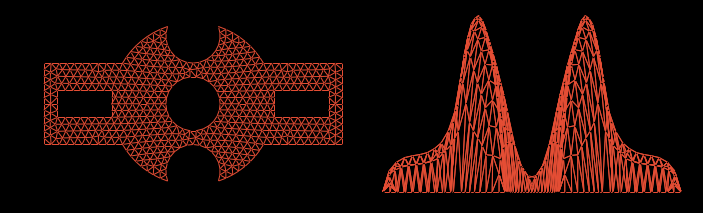

In [566]:

n_free_nodes = len(Data_struct['free_nodes'])
n_fixed_nodes = len(Data_struct['fixed_nodes'])
n_free_edges = len(Data_struct['free_edges'])

# The x,y, and z positions of the fixed nodes. 
# The xs and ys are already chosen (stored in Data_struct['all_poses'] , but we can easily change them and update the "Data_struct"
z_f = 10*np.ones(n_fixed_nodes) - 0.0*np.random.randn(n_fixed_nodes)
# x_f = xy_fixed_nodes[:,0]
# y_f = xy_fixed_nodes[:,1]

# External loads
p_x = 0.0*np.ones((n_free_nodes)) + 0.0*np.random.randn(n_free_nodes)
p_y = -0.0*np.ones((n_free_nodes))
p_z = 5.4*np.ones((n_free_nodes))

q = 2*np.ones((n_free_edges,1)) - 0.0000*np.around(np.random.randn(n_free_edges,1),decimals=1)
Data_struct['q'] = q
Data_struct['z_f'] = z_f
Data_struct['p_x'] = p_x
Data_struct['p_y'] = p_y
Data_struct['p_z'] = p_z
Data_struct = FdmSolver.solve_fdm_Sheck(Data_struct)


# We can plot the the found forms
FdmSolver.plot_form_interactive(Data_struct,fixed_node_size=.71,color='white')
FdmSolver.plot_form_static(Data_struct)
print ('loadpath:{}'.format(FdmSolver.cal_loadpath(Data_struct)['loadpath']))

# Form finding coupled with optimization
* **For a given topology and external loading system, by choosing any set of force densities, q, FDM will find a final shape (form).**
* **But now the question is that which q leads to satisfying results? This is the classical question that usually ends up to the optimization.**
* **The current FDM solver can be easily coupled to any optimization framework such as gradient based approaches (Auto-differentiation) or evolutionary approaches such as GA.**

# Design Space Exploration and Machine Learning
* **Mathematically speaking, with every chosen q, FDM solves a different system of equations, while the topology (structure) of the equations remains the same. If one also thinks about parametrizing the topologies the problem of exploring all the possible geometries will be a tree search problem, where each topology, leads to a fixed system of equations (i.e. a branch) and by varying the force densities (the coefficients of the equations), we have a huge variety of solutions.  Therefore, one of the major limits of FDM is that in a real scenario, the size of the state space increases rapidly and therefore, it will be really difficult to exhaustively explore the space of possible geometries.**
### Here, Machine Learning (ML) methods could be extremely helpful:

* **In the context of surrogate modeling and exploring the design space via given quantitative performance measures**: 
    * Hao Zheng, Vahid Moosavi, Masoud Akbarzadeh, Machine Learning Assisted Evaluations in 3D Graphic Statics, IASS Annual Symposium 2019 - Structural Membranes 2019, Form and Force, 7–10 October 2019, Barcelona, Spain.
    * Liew, A., Avelino, R., Vahid Moosavi, Van Mele, T. and Block, P., Optimising the load-path of compression-only thrust networks through independent sets, Structural and Multidisciplinary Optimization, 1-14, 2019.
    
* **In the context of personalized search with a mixture of quantitative and qualitative measures:** 
    * Karla Saldana Ochoa, Patrick Ole Ohlbrock, Pierluigi D’acunto, Vahid Moosavi, beyond typologies, beyond optimization, IASS Annual Symposium 2019 - Structural Membranes 2019, Form and Force, 7–10 October 2019, Barcelona, Spain.
    * Lukas Fuhrimann, Vahid Moosavi, Patrick Ole Ohlbrock, Pierluigi D’acunto, Data-Driven Design: Exploring new Structural Forms using Machine Learning and Graphic Statics, Proceedings of the IASS Symposium 2018 Creativity in Structural Design July 16-20, 2018, MIT, Boston, USA.
* **In addition, I think it would be great if we think about the whole process of search in the design space in the context of Reinforcement Learning (RL), where an agent can modify the topology and the force densities, while for any decision taken by the agent the FDM solver (the environment) will give an immediate feedback based on a chosen metric. A key question though is the selection of the reward/penalty function.**

# Parametric force densities and design space exploration

# Network Analysis and Centrality Measures
- By changing the values of the force density in each edge of the graph (i.e. coefficient of the systems of equations), every time, we expect to have a different geometry. However, this is not practical.
- One simple idea would be to control the force densities via their importance in the given topology. **Using graph analytics and centrality measures would be a one way to identify the importance of the edges in a graph.** 
- Below we show the distribution of the different edge centrality measures in a given graph. Consequently, we assign the force densities as linear combinations of these centrality measures. 
- **One can think of these centrality measures as a new (not-necessarily orthogonal) basis system**. Similar to what is typically done in matrix decomposition such as PCA or even Fourier Analysis.

In [580]:
path = './Data/'
graph_id = 5
fn = path + '{}.npy'.format(graph_id)
Data_struct = np.load(fn,allow_pickle='TRUE').item()

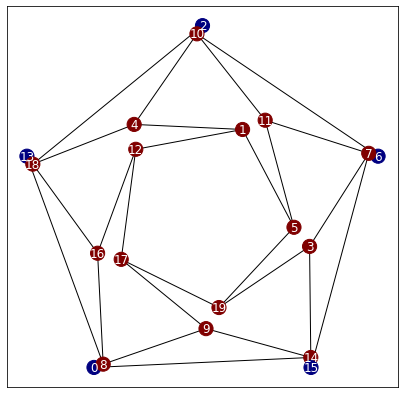

In [581]:
fig = plt.figure(figsize=(7,7))
free_nodes_mask = Data_struct['free_nodes_mask']
G = Data_struct['G']
all_poses = Data_struct['all_poses']
nx.draw_networkx(G,
             pos=all_poses,
             arrows=False,
             width = 1,
             with_labels=True,
             font_color='white',
             node_size=200,
             node_color=free_nodes_mask,
             cmap=plt.cm.jet,
             alpha=1)  

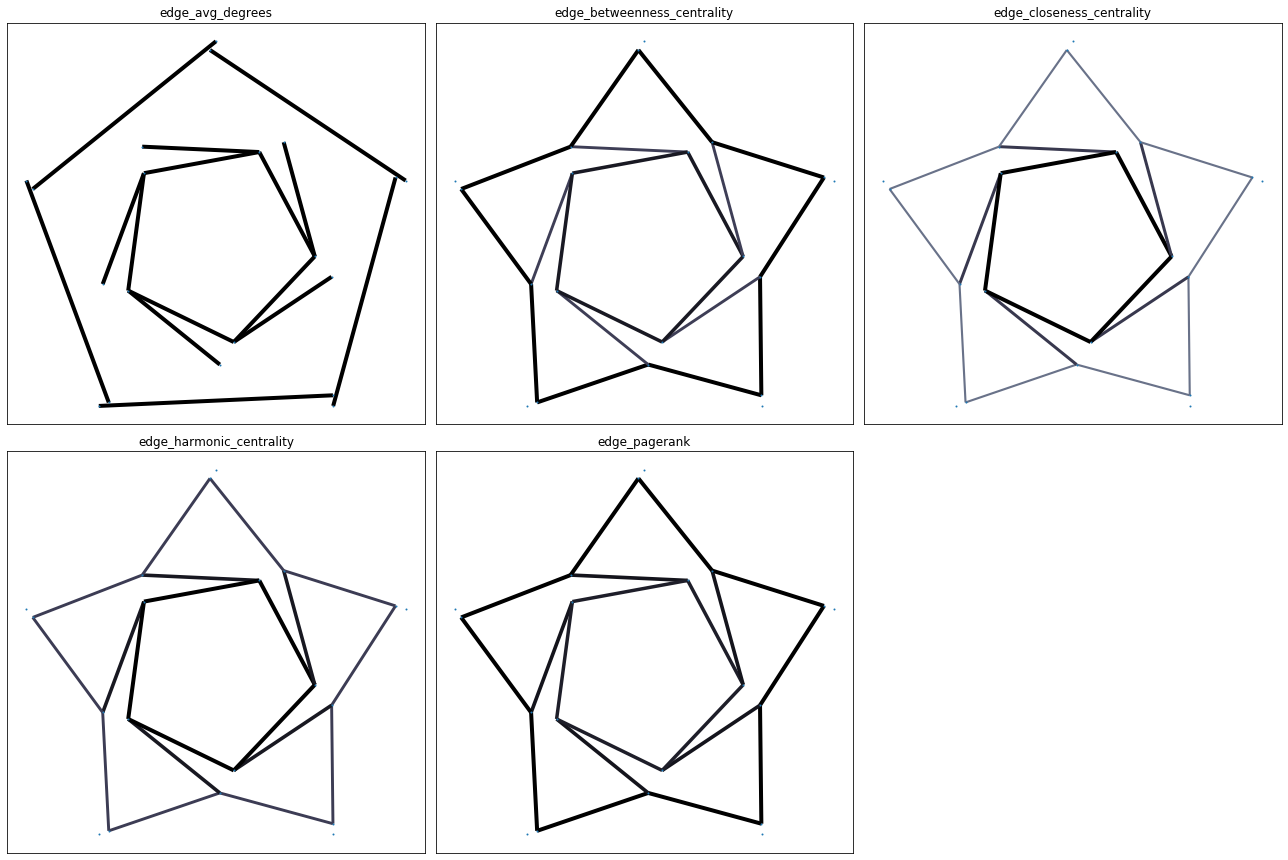

In [582]:
Data_struct = FdmSolver.graph_analytics(Data_struct,vis_analytics=True)

In [583]:
def weighted_vis_sliders(Data_struct,
                         edge_avg_degrees,
                         edge_betweenness_centrality,
                         edge_closeness_centrality,
                         edge_harmonic_centrality,
                         edge_pagerank,
                         z_f,
                         p_x,
                         p_y,
                         p_z,                 
        plot_force_density,
        plot_interactive,
        plot_form_projection):
    
    weights  = np.asarray([edge_avg_degrees,
                         edge_betweenness_centrality,
                         edge_closeness_centrality,
                         edge_harmonic_centrality,
                         edge_pagerank])
    
    
    n_free_nodes = len(Data_struct['free_nodes'])
    n_free_nodes = len(Data_struct['free_nodes'])
    n_fixed_nodes = len(Data_struct['fixed_nodes'])
    n_free_edges = len(Data_struct['free_edges'])
    p_x = p_x*np.ones((n_free_nodes))
    p_y = p_y*np.ones((n_free_nodes))
    p_z = p_z*np.ones((n_free_nodes))    
    z_f = z_f*np.ones(n_fixed_nodes)
    
    Data_struct['p_x'] = p_x
    Data_struct['p_y'] = p_y
    Data_struct['p_z'] = p_z
    Data_struct['z_f'] = z_f

    measures = [Data_struct['graph_analytics'][k] for k in Data_struct['graph_analytics'].keys()]
    measures = np.asarray(measures).T
    weighted_measures = measures.dot(weights)[:,np.newaxis]
    Data_struct['q'] = np.ones((n_free_edges,1)) + weighted_measures
    try:
        Data_struct = FdmSolver.solve_fdm_Sheck(Data_struct)

        weighted_measures = measures.dot(weights)[:,np.newaxis]    
        n_free_edges = len(Data_struct['free_edges'])
        n_free_nodes = len(Data_struct['free_nodes'])
        if plot_force_density == True:
            fig = plt.figure(figsize=(4,4))
            ax  = plt.subplot(1,1,1)
            G = Data_struct['G']
            all_poses = Data_struct['all_poses']
            col = weighted_measures[:,0]
            nx.draw_networkx(G,
                         pos=all_poses,
                         arrows=False,
                         edge_color=list(col),
                         edge_cmap = plt.cm.bone_r,
    #                      edge_vmin = 0,
    #                      edge_vmax = 1.,
                         width = list(col),
                         with_labels=False,
                         font_color='white',
                         node_size=1,
                         cmap=plt.cm.jet,
                         alpha=1)    
            plt.tight_layout()

        if plot_form_projection == True:
            FdmSolver.plot_form_static(Data_struct,xy_only=False)

        if plot_interactive == True:
    #         ax  = plt.subplot(1,2,2)
            FdmSolver.plot_form_interactive(Data_struct,fixed_node_size=.71,color='white')
    except:
        print ('change the values')

In [584]:
from ipywidgets import interact, HTML, FloatSlider, fixed, IntSlider, HBox, VBox
import ipywidgets as widgets


# it starts with q =1 for all the edges
edge_betweenness = FloatSlider(0.0,min=-5,max=5,step=.2)
edge_avg_degrees = FloatSlider(0.0,min=-5,max=5,step=.2)
edge_betweenness_centrality = FloatSlider(0.0,min=-5,max=5,step=.2)
edge_closeness_centrality = FloatSlider(0.0,min=-5,max=5,step=.2)
edge_degree_centrality = FloatSlider(0.0,min=-5,max=5,step=.2)
edge_harmonic_centrality = FloatSlider(0.0,min=-5,max=5,step=.2)
edge_pagerank = FloatSlider(0.0,min=-5,max=5,step=.2)


z_f = FloatSlider(1.0,min=-4,max=4,step=.2)

p_x = FloatSlider(0.0,min=-4,max=4,step=.2)
p_y = FloatSlider(0.0,min=-4,max=4,step=.2)
p_z = FloatSlider(2.0,min=-4,max=4,step=.2)
plot_force_density = fixed(True)
plot_interactive = fixed(False)
plot_form_projection = fixed(True)
plot_interactive = widgets.Checkbox(
    value=False,
    description='plot_interactive',
    disabled=False
)
plot_force_density = widgets.Checkbox(
    value=False,
    description='plot_force_density',
    disabled=False
)

plot_form_projection = widgets.Checkbox(
    value=True,
    description='plot_form_projection',
    disabled=False
)

title_widgets = [widgets.HTML('<em>{}</em>'.format(k)) for k in Data_struct['graph_analytics'].keys()]
hb1 = HBox([
            title_widgets[0],edge_avg_degrees,
            title_widgets[1],edge_betweenness_centrality,
            title_widgets[2], edge_closeness_centrality],box_style='danger')
hb2 = HBox([
            title_widgets[3],edge_harmonic_centrality,
            title_widgets[4], edge_pagerank],box_style='success')
#             title_widgets[5],edge_harmonic_centrality],box_style='success')

hb3 = HBox([
#             title_widgets[6],edge_pagerank,
#             widgets.HTML('<em>{}</em>'.format('fixed_x')),x_f,
#             widgets.HTML('<em>{}</em>'.format('fixed_y')),y_f,
            widgets.HTML('<em>{}</em>'.format('fixed_z')),z_f],
            box_style='info')

hb4 = HBox([
#             title_widgets[6],edge_pagerank,
            widgets.HTML('<em>{}</em>'.format('load_x')),p_x,
            widgets.HTML('<em>{}</em>'.format('load_y')),p_y,
            widgets.HTML('<em>{}</em>'.format('load_z')),p_z],box_style='info')
# hb4 = HBox([vis_analytics,plot_interactive,plot_form_projection,verbose])
vi = VBox([hb1,hb2,hb3,hb4])
out = widgets.interactive_output(weighted_vis_sliders, {
    'Data_struct': fixed(Data_struct),
#     'edge_betweenness': edge_betweenness,
    'edge_avg_degrees': edge_avg_degrees,
    'edge_betweenness_centrality':edge_betweenness_centrality,
    'edge_closeness_centrality':edge_closeness_centrality,
#     'edge_degree_centrality':edge_degree_centrality,
    'edge_harmonic_centrality':edge_harmonic_centrality,
    'edge_pagerank':edge_pagerank,
#     'x_f': fixed(xy_fixed_nodes[:,0]),
#     'y_f': fixed(xy_fixed_nodes[:,1]),
    'z_f':z_f,
    'p_x':p_x,
    'p_y':p_y,
    'p_z':p_z,
    'plot_force_density':plot_force_density,
    'plot_interactive':plot_interactive,
    'plot_form_projection':plot_form_projection
})


display(vi, out)
display(plot_interactive)
display(plot_force_density)
display(plot_form_projection)

Output()

Checkbox(value=False, description='plot_interactive')

Checkbox(value=False, description='plot_force_density')

Checkbox(value=True, description='plot_form_projection')

# The case of a stadium roof
- In addition to use of network centralities as a parametrization of the force densities, in other cases, depending on the case and the chosen topology, one can come up with different parametrizations. Below you see an example of a stadium roof, where the fixed points are lying on a circle. 

### For further details about this case, please look at the paper below:
* Karla Saldana Ochoa, Patrick Ole Ohlbrock, Pierluigi D’acunto, Vahid Moosavi, beyond typologies, beyond optimization, IASS Annual Symposium 2019 - Structural Membranes 2019, Form and Force, 7–10 October 2019, Barcelona, Spain.


In [586]:
path = './Data/'
graph_id = 'stadium'
fn = path + '{}.npy'.format(graph_id)
Data_struct = np.load(fn,allow_pickle='TRUE').item()

## One idea for parametrization of the force densities
## trail members vs. deviation members

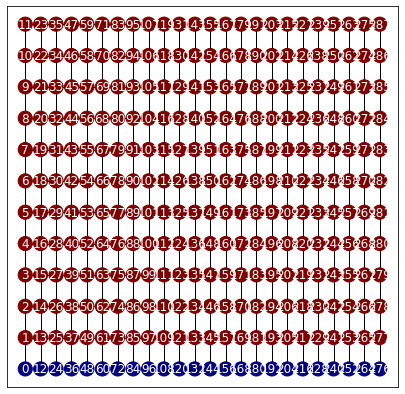

In [587]:
fig = plt.figure(figsize=(7,7))
free_nodes_mask = Data_struct['free_nodes_mask']
G = Data_struct['G']
all_poses = Data_struct['all_poses']
nx.draw_networkx(G,
             pos=all_poses,
             arrows=False,
             width = 1,
             with_labels=True,
             font_color='white',
             node_size=200,
             node_color=free_nodes_mask,
             cmap=plt.cm.jet,
             alpha=1)  

In [588]:
all_poses = Data_struct['all_poses'].copy()
fixed_nodes = Data_struct['fixed_nodes']
free_edges = Data_struct['free_edges'] 
G = Data_struct['G']
fixed_nodes
r = 10
center = [0,0]
n_cols = len(fixed_nodes)
n_nodes = len(G.node)
n_rows = int(n_nodes/n_cols)
rows = [list(range(i,n_nodes,n_rows)) for i in range(n_rows)]
cols = [list(range(i,i+n_rows)) for i in range(0,n_nodes,n_rows)]
DF_edges = pd.DataFrame(data=free_edges,columns=['u','v'])
DF_edges.head()
which_row = np.zeros(DF_edges.shape[0]).astype(int)
which_col = np.zeros(DF_edges.shape[0]).astype(int)
is_vertical = np.zeros(DF_edges.shape[0])
for j in range(DF_edges.shape[0]):
    e = list(DF_edges.values[j])
    for i in range(len(rows)):
        if len(set(rows[i]).intersection(set([e[0]])))==1:
            which_row[j] = int(i)
        if len(set(rows[i]).intersection(e))==2:
#             which_col[j] = -1
            is_vertical[j] = 0
    for i in range(len(cols)):
        if len(set(cols[i]).intersection(set([e[0]])))==1:
#             which_row[j] = -1
            which_col[j] = int(i)
        if len(set(cols[i]).intersection(e))==2:
            is_vertical[j] = 1
DF_edges['col_number'] = which_col
DF_edges['is_vertical'] = is_vertical
DF_edges['row_number'] = which_row
DF_edges.tail(12)

u    v  col_number  is_vertical  row_number
516  281    5          23          0.0           5
517  282  283          23          1.0           6
518  282    6          23          0.0           6
519  283  284          23          1.0           7
520  283    7          23          0.0           7
521  284  285          23          1.0           8
522  284    8          23          0.0           8
523  285  286          23          1.0           9
524  285    9          23          0.0           9
525  286  287          23          1.0          10
526  286   10          23          0.0          10
527  287   11          23          0.0          11

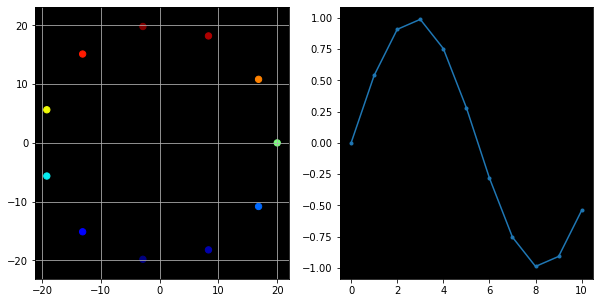

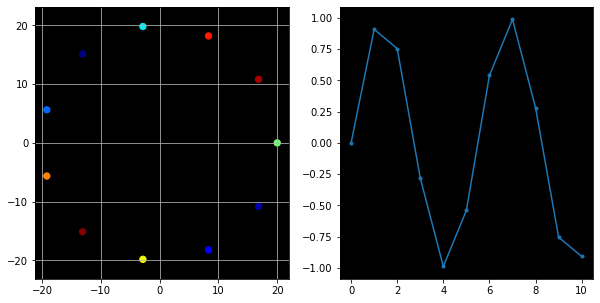

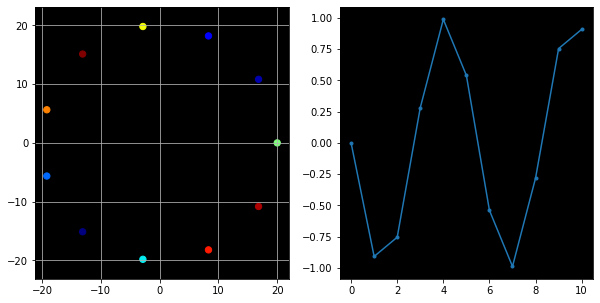

In [589]:
# The force densities in each trail line (connections from the top to the fixed points) are connected via a trigonometric function
def vis_harmonic(Amp=1,freq=2,phase_s=0):
    # Here, we need to assign 11 values for each path from the top to the supports (fixed points)
    n_rows = 11
    facecolor = 'black'
    phase_s = phase_s*np.pi
    angles = [(freq*np.pi*float(k)/n_rows)-phase_s for k in range(0,n_rows)]
    vals = Amp*np.sin(angles)
    
    r = 20
    center = [0,0]
    angles = [2*np.pi*i/n_rows for i in range(n_rows)]
    xy_fixed_nodes = [[r*np.cos(a),r*np.sin(a)] for a in angles]
    xy_fixed_nodes = np.asarray(xy_fixed_nodes)
    
    mn = np.min(vals)
    mx = np.max(vals)
    fig = plt.figure(figsize=(10,5))
    ax  = plt.subplot(1,2,1)
    ax.set_facecolor(facecolor)
    plt.scatter(xy_fixed_nodes[:,0],xy_fixed_nodes[:,1],s=40,c=vals,cmap=plt.cm.jet,vmin=mn,vmax=mx);
    plt.grid();
    plt.axis('equal');
    ax  = plt.subplot(1,2,2)
    ax.set_facecolor(facecolor)
    plt.plot(vals,'.-');
vis_harmonic(Amp=1,freq=2,phase_s=0)
vis_harmonic(Amp=1,freq=4,phase_s=0)
vis_harmonic(Amp=1,freq=4,phase_s=-1)

In [590]:
interact(vis_harmonic,
         Amp=FloatSlider(1.0,min=-5,max=20,step=.1),
         freq=FloatSlider(2.0,min=0,max=100,step=1),
         phase_s=FloatSlider(0.0,min=-2,max=2,step=.5))

interactive(children=(FloatSlider(value=1.0, description='Amp', max=20.0, min=-5.0), FloatSlider(value=2.0, de…

<function __main__.vis_harmonic>

In [591]:
def parametric_solver(Data_struct,
                      p_z=.1,
                      base_radius=10,
                      Amp_trail=1,
                      phase_trail=0,
                      coef_trail=2,
                      fixed_minimum_trail=.3,
                      Amp_deviation=1,
#                       phase_deviation=0,
#                       coef_deviation=2,
                      plot_interactive = True,
                      verbose=True,
                      plot_form_projection=False
                     ):
    n_free_nodes = len(Data_struct['free_nodes'])
    n_fixed_nodes = len(Data_struct['fixed_nodes'])
    n_cols = np.max(DF_edges['col_number'])+1
    n_rows = np.max(DF_edges['row_number'])+1
    r = base_radius
    center = [0,0]
    angles = [2*np.pi*i/n_cols for i in range(n_cols)]
    xy_fixed_nodes = [[r*np.cos(a),r*np.sin(a)] for a in angles]
    xy_fixed_nodes = np.asarray(xy_fixed_nodes)
    z_f = 0*np.ones(n_fixed_nodes) - 0.0*np.random.randn(n_fixed_nodes)
    x_f = xy_fixed_nodes[:,0]
    y_f = xy_fixed_nodes[:,1]
    p_x = .0*np.ones((n_free_nodes)) + 0.0*np.random.randn(n_free_nodes)
    p_y = -.0*np.ones((n_free_nodes))
    p_z = p_z*np.ones((n_free_nodes))
    q = np.ones(DF_edges.shape[0])
    q = np.zeros(DF_edges.shape[0])
    eps = .00001
    # give the same value to vertical elements in each row
    # Trail members
    factor = np.random.choice(range(n_cols),size=n_cols,replace=False)
    factor = range(n_cols)
    for i in range(n_cols):
        ind_ = DF_edges.loc[(DF_edges['col_number']==i) & (DF_edges['is_vertical']==1)].index[:].values[:]
        Amp = Amp_trail*(0+1)/1.0
        freq = coef_trail
#         factor = np.random.randint(-1,high=2,size=1)[0]
        
        phase_s = (factor[i]+phase_trail)*np.pi
        angles = [(freq*np.pi*float(k)/(n_rows-1))-phase_s for k in range(0,n_rows-1)]
        vals = Amp*np.sin(angles) + fixed_minimum_trail
        
#         vals = .1
        
        if len(ind_)>1:
            q[ind_] = vals

    # give the same value in horizontal edges in each column
#     Deviation
    for i in range(n_rows):
        ind_ = DF_edges.loc[(DF_edges['row_number']==i) & (DF_edges['is_vertical']==0)].index[:].values[:]
        vals = Amp_deviation*(i+1)
        if len(ind_)>1:
            q[ind_] = vals
    n_free_edges = len(Data_struct['free_edges'])
    n_free_nodes = len(Data_struct['free_nodes'])
    Data_struct['q'] = q
    Data_struct['p_x'] = p_x
    Data_struct['p_y'] = p_y
    Data_struct['p_z'] = p_z
    Data_struct['x_f'] = x_f
    Data_struct['y_f'] = y_f
    Data_struct['z_f'] = z_f
    
    
    # Now solve FDM
    Data_struct = FdmSolver.solve_fdm_Sheck(Data_struct,plot_topologies=False)
    Data_struct = FdmSolver.cal_loadpath(Data_struct)
    
    if plot_form_projection == True:
        FdmSolver.plot_form_static(Data_struct)
    
    if verbose == True:
        print ('loadpath:{}'.format(FdmSolver.cal_loadpath(Data_struct)['loadpath']))
    if plot_interactive == True:
        FdmSolver.plot_form_interactive(Data_struct,fixed_node_size=.71)
    
    return Data_struct

In [592]:
from fdmlib import fdm
import sys,importlib
importlib.reload(fdm)
FdmSolver = fdm.FDM()
_ = interactive(parametric_solver,
         Data_struct=fixed(Data_struct),
         p_z = FloatSlider(0.5,min=.0,max=2,step=.01),
         base_radius = FloatSlider(20.0,min=1,max=200,step=1),
         Amp_trail=FloatSlider(0.0,min=-5,max=10,step=.05),
         phase_trail=FloatSlider(0.0,min=-2,max=2,step=.05),
         coef_trail=FloatSlider(1.0,min=-20,max=20,step=.1),
         fixed_minimum_trail = FloatSlider(0.3,min=0.0,max=4,step=0.1),
         Amp_deviation=FloatSlider(.05,min=-1,max=1,step=.01),
#          phase_deviation = FloatSlider(0.0,min=-2,max=2,step=.05),
#          coef_deviation=FloatSlider(1.0,min=-20,max=20,step=1),
         plot_interactive = True,
         verbose=fixed(True),
         plot_form_projection=False
        );
display(_)

interactive(children=(FloatSlider(value=0.5, description='p_z', max=2.0, step=0.01), FloatSlider(value=20.0, d…

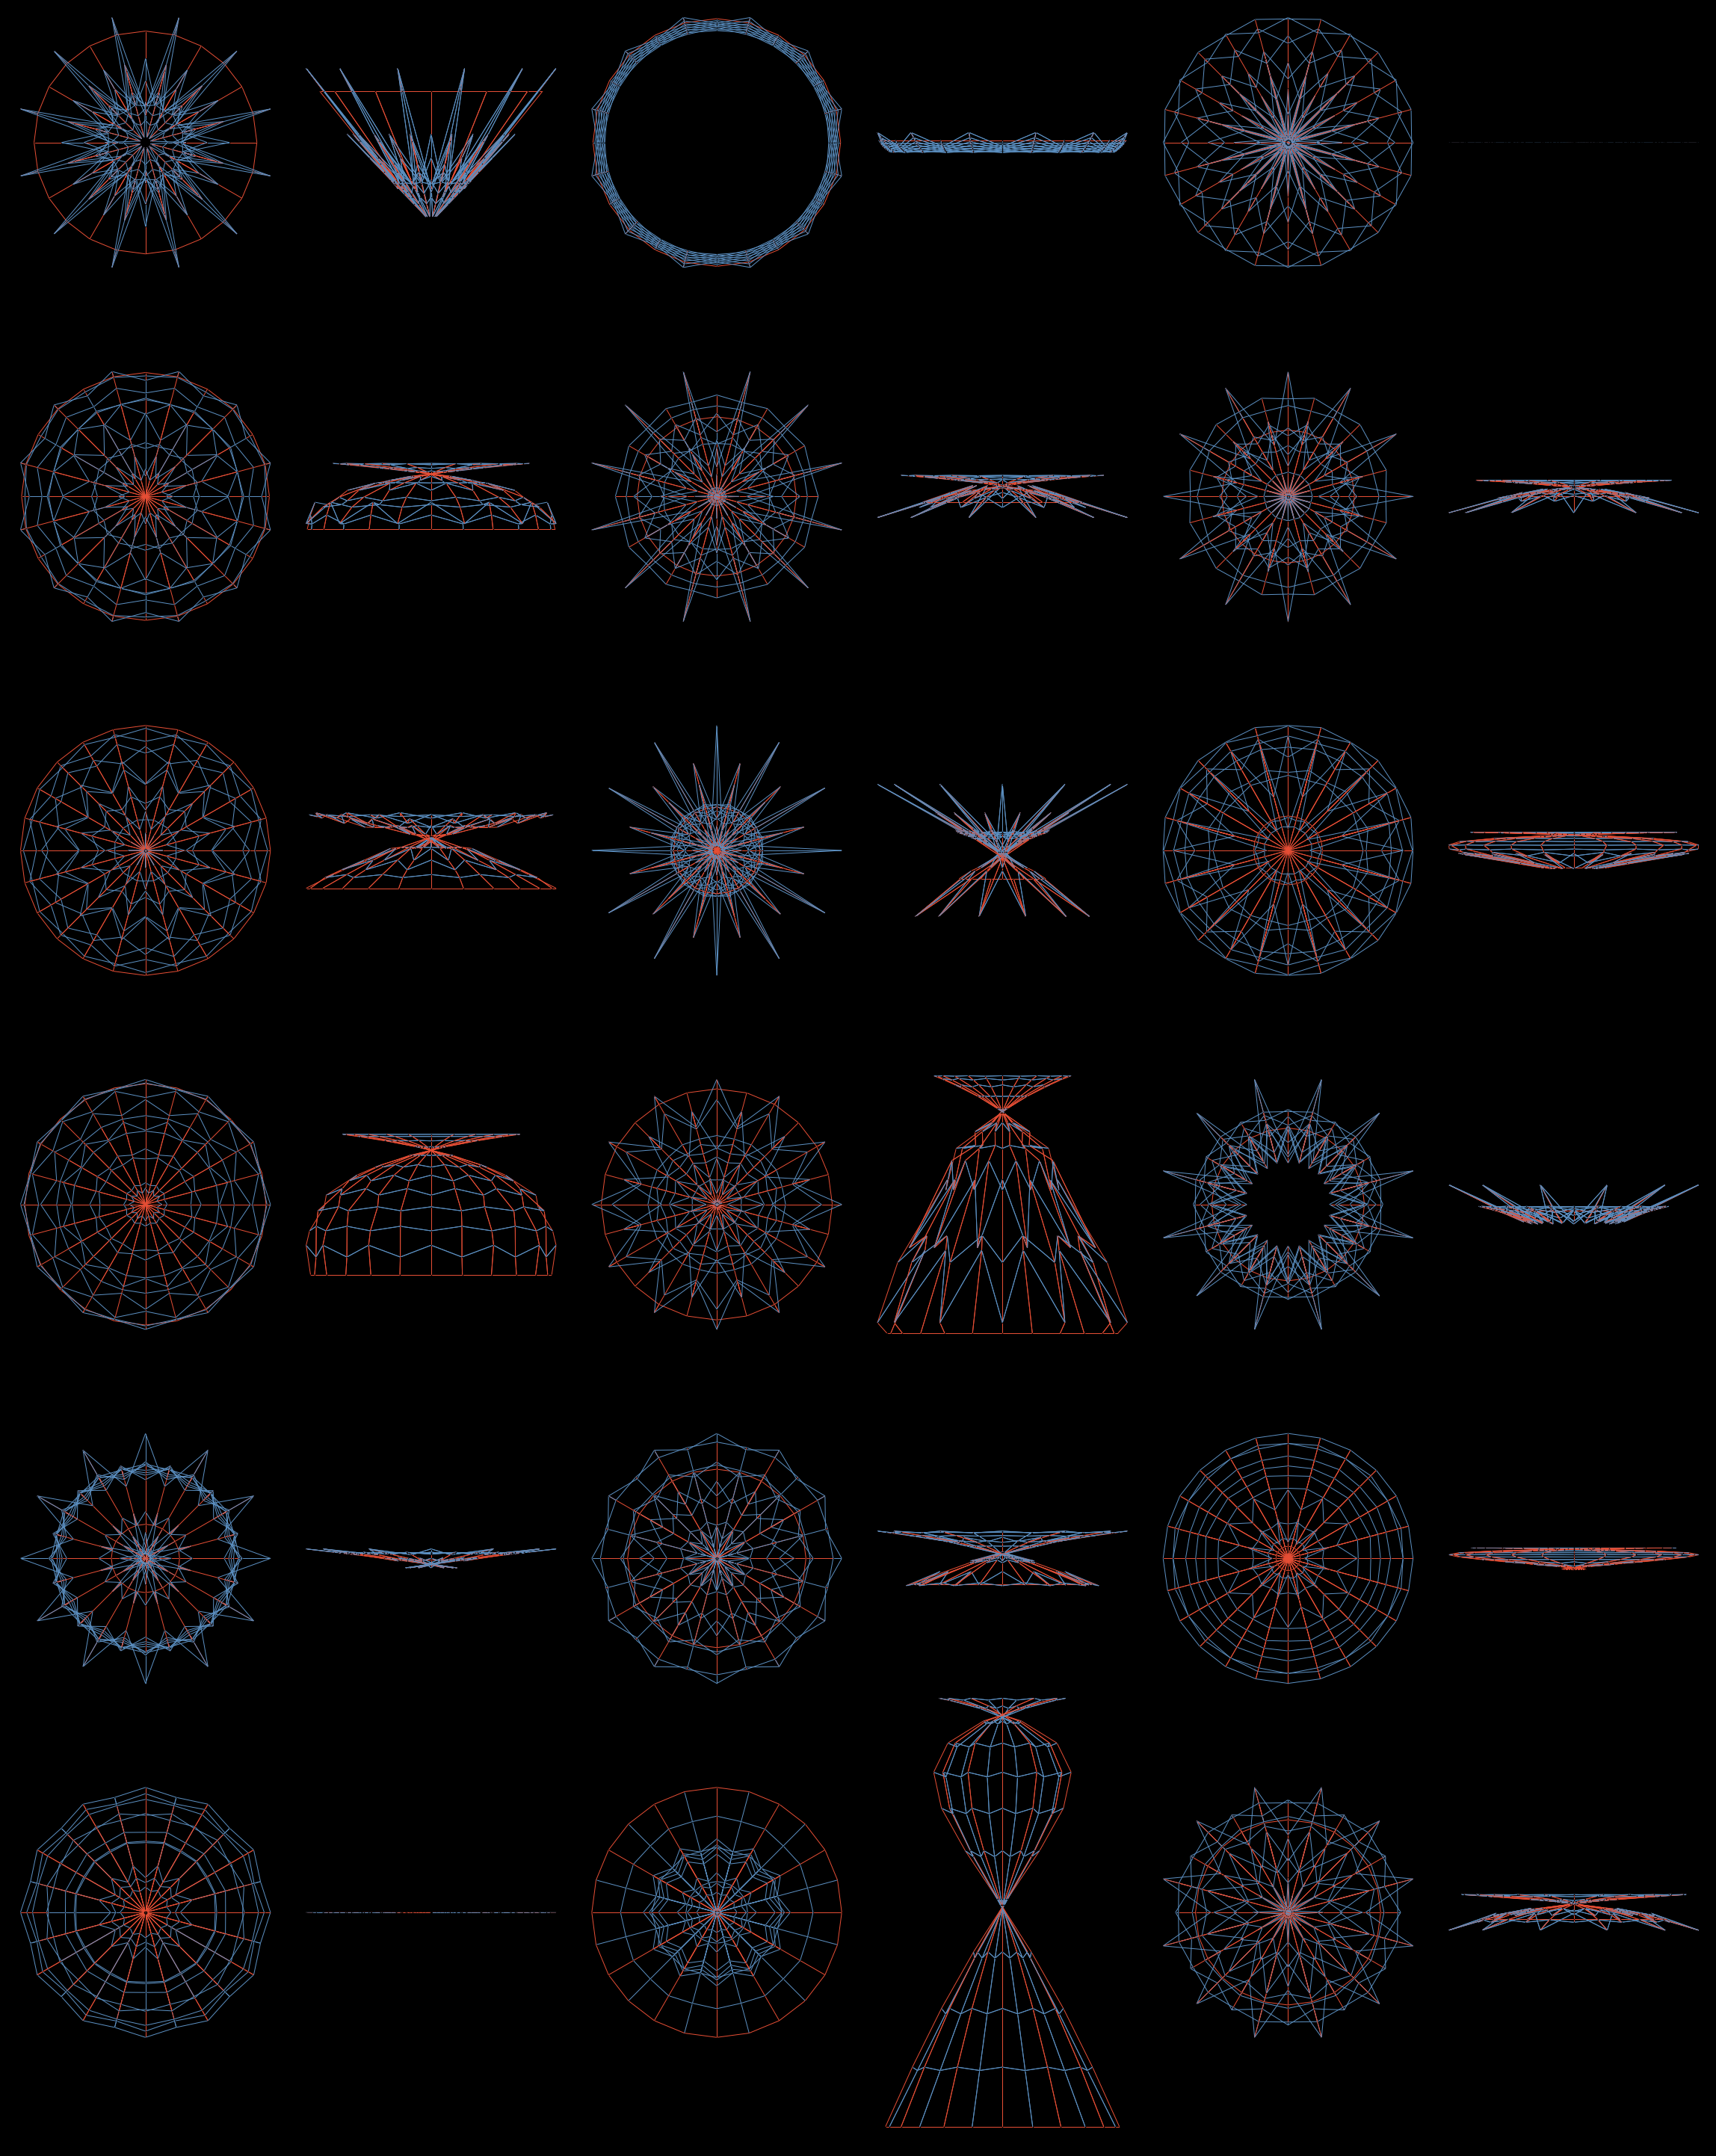

In [593]:
rows = 6
xy_only=False
fig, axs = plt.subplots(rows, 6,figsize=(32,42),facecolor='black',sharex=False, sharey=False)
for i in range(3*rows):
    Amp_trail = -5+ 10*np.random.rand()
    phase_trail = -2+ 4*np.random.rand()
    coef_trail = -(n_rows-1)*4+ 2*((n_rows-1)*4)*np.random.rand() 
    fixed_minimum_trail= 0.0 + 3*np.random.rand()
    Amp_deviation= -.5+ .5*np.random.rand()
    params = [Amp_trail] + [phase_trail] + [coef_trail] + [fixed_minimum_trail] + [Amp_deviation]
    Input_params_names = ['Amp_trail','phase_trail','coef_trail','fixed_minimum_trail','Amp_deviation']
#     try:
    res = parametric_solver(Data_struct,
                  p_z=.5,
                  base_radius=20,
                  Amp_trail=Amp_trail,
                  phase_trail=phase_trail,
                  coef_trail=coef_trail,
                  fixed_minimum_trail=fixed_minimum_trail,
                  Amp_deviation=Amp_deviation,
                  plot_interactive = False,
                  verbose=False,
                  plot_form_projection=False
                 )
    if i <rows:
        ll = [axs[i,0],axs[i,1]]
    elif rows<=i<2*rows:
        ll = [axs[i-rows,2],axs[i-rows,3]]
    else:
        ll = [axs[i-2*rows,4],axs[i-2*rows,5]]
    FdmSolver.plot_form_static(res,axs=ll,xy_only=xy_only)
#     except:
#         pass
# fig.savefig('./Images/{}x{}_xyonly_{}.png'.format(rows,cols,xy_only),facecolor='k', edgecolor='k',dpi=200)
# plt.close()

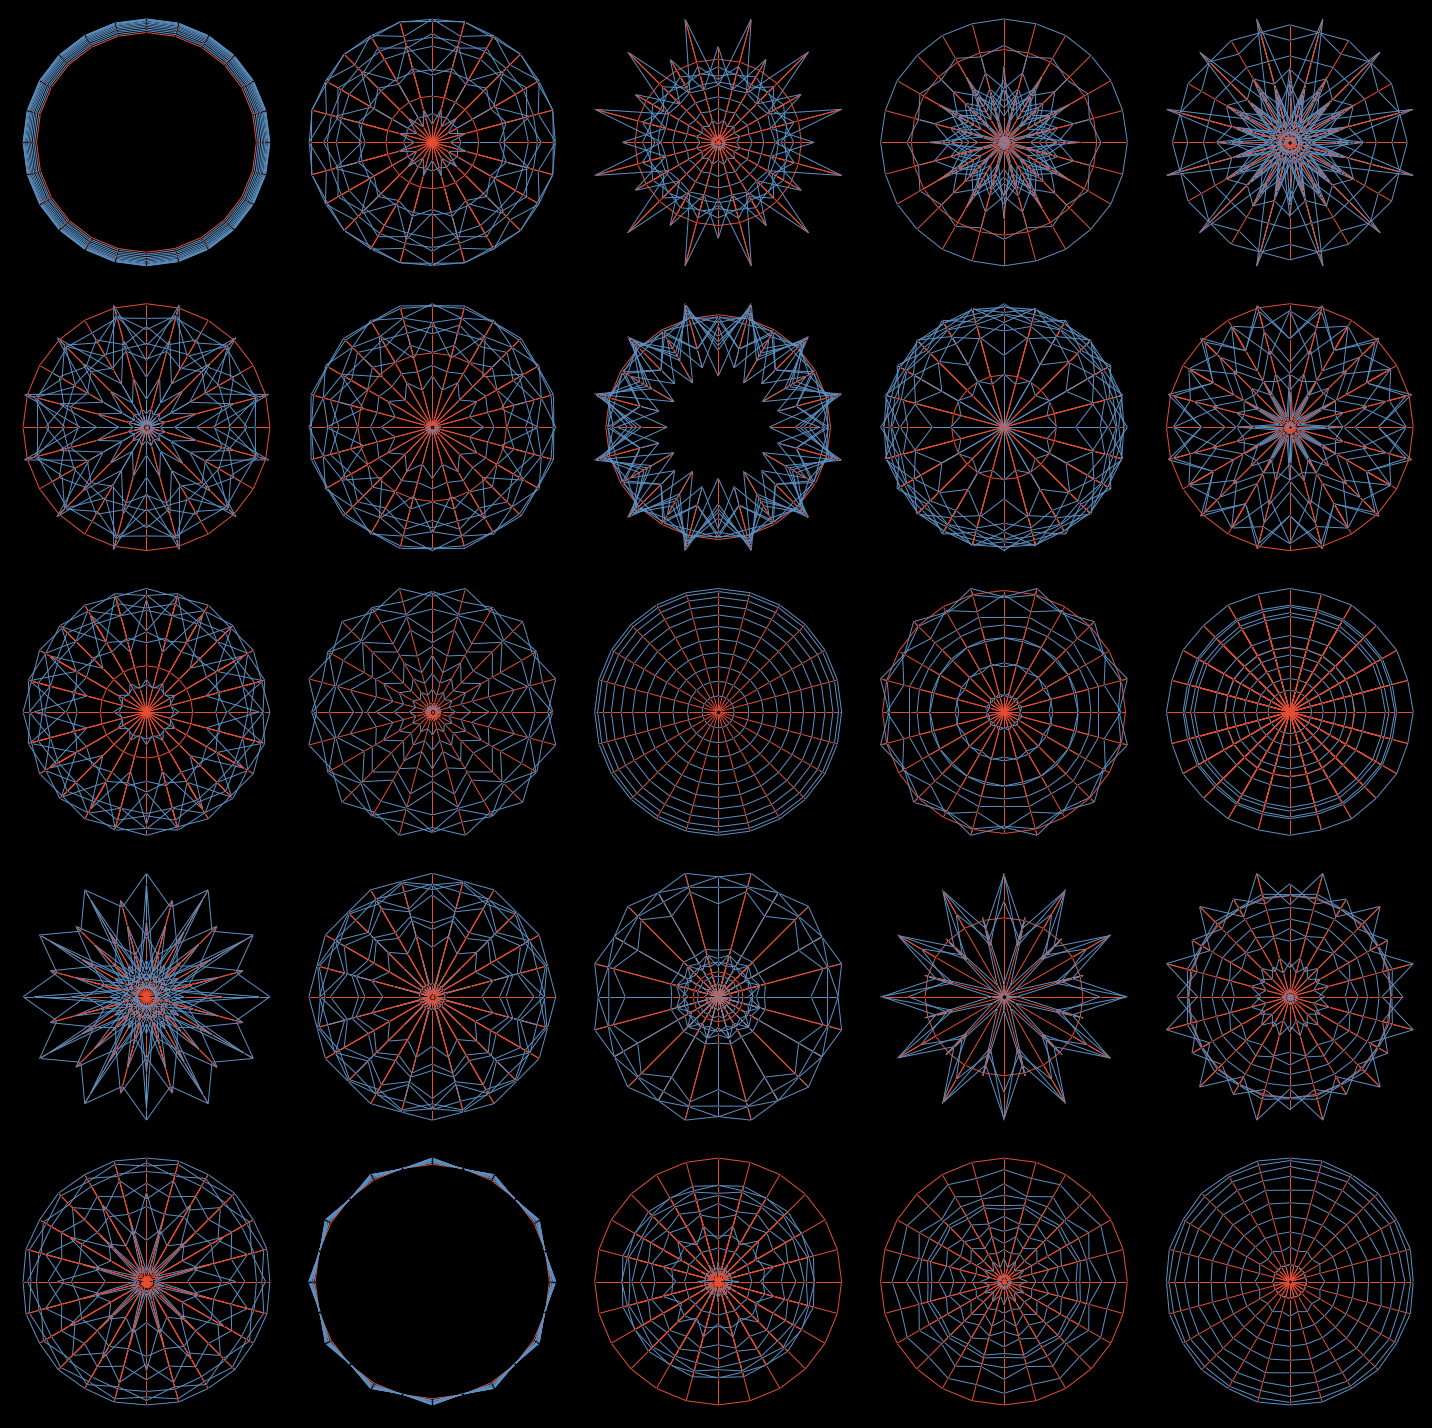

In [604]:
# xy_only
rows = 5
cols = 5
xy_only = True

fig, axs = plt.subplots(cols,rows,figsize=(rows*4,cols*4),facecolor='black',sharex=False, sharey=False)
for i in range(cols*rows):
    Amp_trail = -5+ 10*np.random.rand()
    phase_trail = -2+ 4*np.random.rand()
    coef_trail = -(n_rows-1)*4+ 2*((n_rows-1)*4)*np.random.rand() 
    fixed_minimum_trail= 0.0 + 5*np.random.rand()
    Amp_deviation= -1.5+ 1.5*np.random.rand()
    params = [Amp_trail] + [phase_trail] + [coef_trail] + [fixed_minimum_trail] + [Amp_deviation]
    Input_params_names = ['Amp_trail','phase_trail','coef_trail','fixed_minimum_trail','Amp_deviation']

    res = parametric_solver(Data_struct,
                  p_z=.5,
                  base_radius=20,
                  Amp_trail=Amp_trail,
                  phase_trail=phase_trail,
                  coef_trail=coef_trail,
                  fixed_minimum_trail=fixed_minimum_trail,
                  Amp_deviation=Amp_deviation,
                  plot_interactive = False,
                  verbose=False,
                  plot_form_projection=False
                 )
    r = i//rows
    c = i%rows
    ll = [axs[r,c]]
    FdmSolver.plot_form_static(res,axs=ll,xy_only=xy_only)
# fig.savefig('./Images/{}x{}_xyonly_{}.png'.format(rows,cols,xy_only),facecolor='k', edgecolor='k',dpi=100)
# plt.close()